# **一个基于集成学习的高级预测模型**


## 目录

#### 第一节: 问题描述

#### 第二节: 问题分析
1)Adding any few features.

2)Removing redundant features.

3)Converting features into suitable form for modeling.
#### 第三节: 问题建模
1)Running Basic Algorithms.

2)Cross Validation.

3)Ensembling.

4)Important Features Extraction.
#### 第四节: 模型求解

#### 第五节: 结果分析与讨论

# **问题描述**

泰坦尼克号的沉没是历史上最臭名昭著的灾难之一。

1912年4月15日，在她的首航中，“泰坦尼克号”在与冰山相撞后沉没。不幸的是，船上没有足够的救生艇，导致共2224名乘客和船员中的1502人死亡。

研究表明，有些群体比其他群体更有可能生存下来。

建立一个预测模型，使用乘客数据，来解决哪些人更有可能生存。

# **问题分析**
## Part1: 探索性资料分析(EDA)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data=pd.read_csv('../input/train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.isnull().sum() #checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age、Embarked和Cabin均存在缺失数据，缺失数据需要进行数据清洗处理；缺失值处理常用方法：

- 如果是数值类型，用平均值取代
- 如果是分类数据，用最常见的类别取代
- 使用模型预测缺失值，例如：K-NN
对于Age（年龄）和Fare（船票价格）两个数值类型字段，缺失的部分采用最简单的方法平均数来填充；

### 我们来看一下存活与遇难人数比例情况

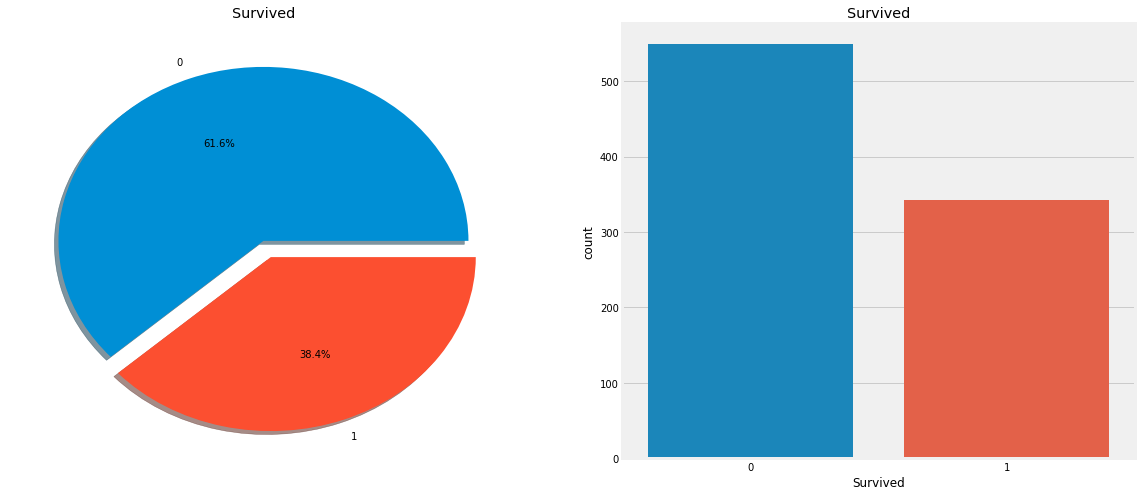

In [5]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

可以看出大多数旅客没有幸存
训练集总共891名乘客，只有350人幸存，占比为**38.4%**


下面我们来理解一下各个特征


## 特征类型

### Categorical Features:
分类变量是一个具有两个或两个以上类别的变量，该特性中的每个值都可以被它们分类。例如，性别是一个分类变量，有两个类别(男性和女性)。现在我们无法对这些变量进行排序或排序。它们也被称为“名义变量”。**Nominal Variables**.

本数据集中的分类特征：Sex, Embarked

### Ordinal Features:
序数变量类似于分类值，但它们之间的区别是，我们可以对值进行相对排序或排序。

本数据集中的序数特征：Pclass 客舱等级
*1=1等舱，2=2等舱，3=3等舱*

### Continous Feature:
如果一个特征可以取任意两点之间的值，或者特征列中的最小值或最大值之间的值，那么这个特征就是连续的。
本数据集中的连续特征：Age

## Analysing The Features 分析特征

## 性别 Sex--> Categorical Feature

In [6]:
data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

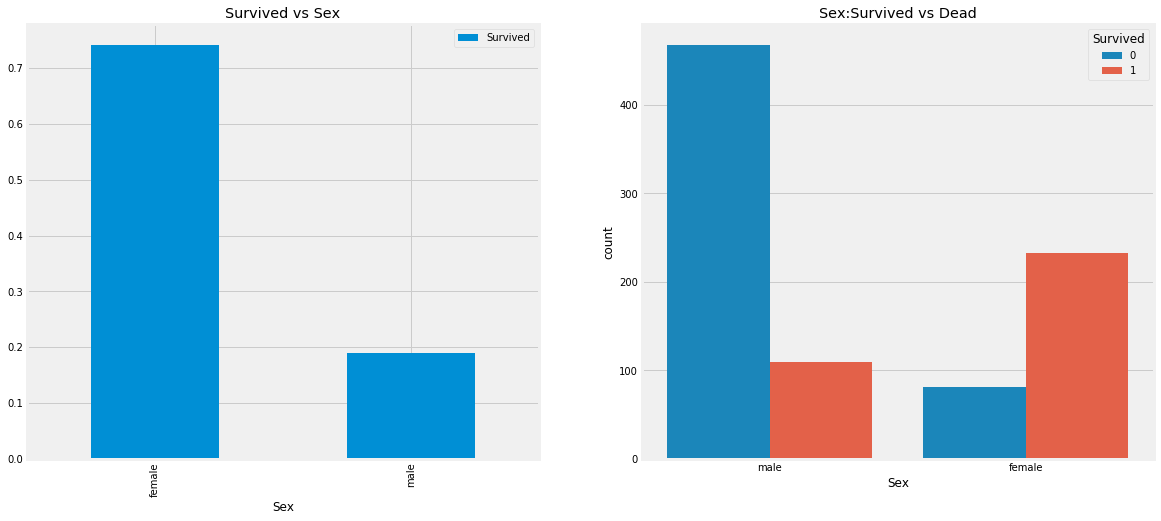

In [7]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

船上的男人比女人多很多。然而，女性获救人数几乎是男性获救人数的两倍。**船上女性的存活率约为75%，而男性的存活率约为18-19%。**

## 客舱等级 Pclass --> Ordinal Feature

In [8]:
pd.crosstab(data.Pclass,data.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


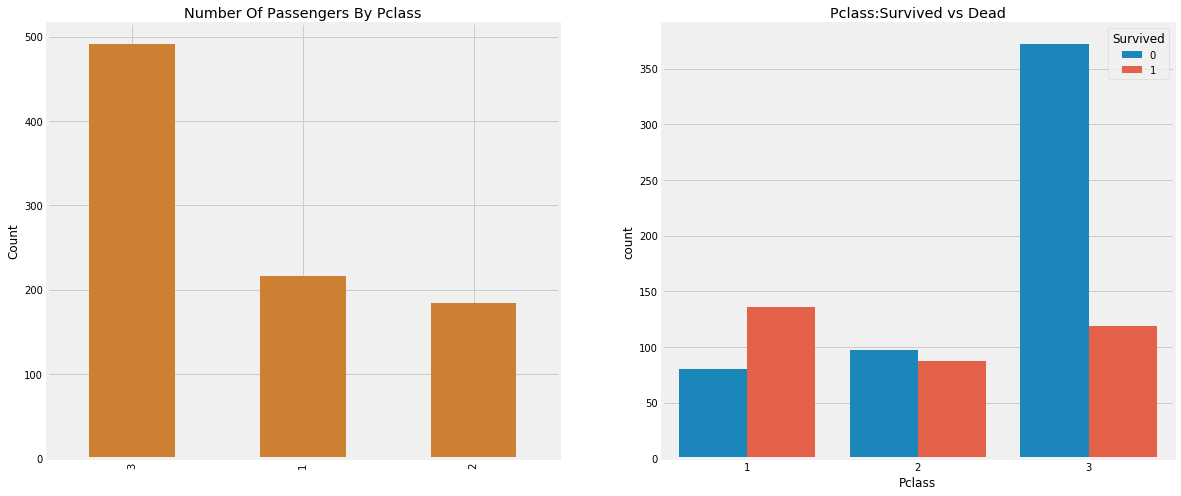

In [9]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

人们常说金钱不能买到一切。但我们可以清楚地看到，Pclass 1的乘客在救援时被给予了非常高的优先级。尽管Pclass 3的乘客数量要高得多，但幸存的人数仍然很低，大约在25%左右。

Pclass 1%的存活率约为63%，而Pclass2约为48%。所以金钱和地位很重要。

让我们深入一点，看看其他有趣的观察结果。让我们用**性别和Pclass**一起来检查生存率。

In [10]:
pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True).style.background_gradient(cmap='summer_r')

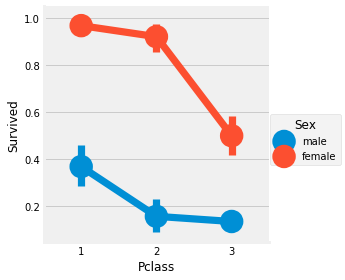

In [11]:
sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

在这种情况下，我们使用**FactorPlot**，因为它们使分类值的分离变得容易。

通过**交叉表**和**因子图**，我们可以很容易地推断出来自Pclass1的**女性的存活率大约是95-96%**，因为来自Pclass1的94名女性中只有3人死亡。

很明显，不管等级高低，女性在救援时被优先考虑。即使是来自class1的男性也有非常低的存活率。

## Age--> Continous Feature


In [12]:
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years')
print('Average Age on the ship:',data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


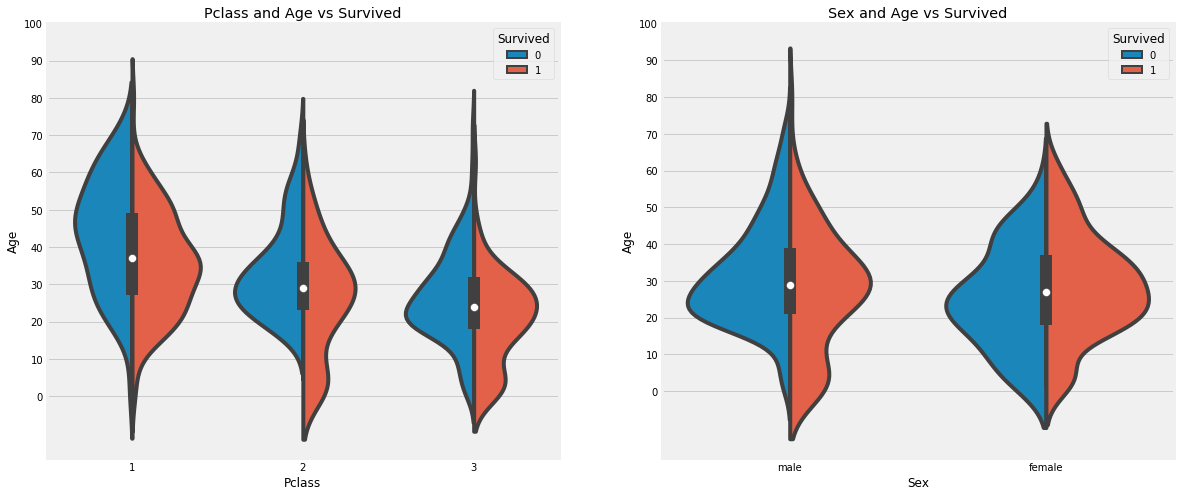

In [13]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

#### 观察结果:

1)儿童的数量随着Pclass的增加而增加，10岁以下乘客的存活率都很好，不管他们属于哪个阶级。

2)一班乘客年龄在20-50岁之间，生还几率很高，女性乘客的生还几率更高。

3)对于男性来说，存活的机会随着年龄的增长而减少。

正如我前面所说的，Age特性有**177**空值。要替换这些NaN值，我们可以给它们分配数据集的平均年龄。

**特别的**, 我们可以查看**Name**特性。从特征上看，我们可以看到每个名字有一个称呼，如先生或夫人，因此我们可以将先生和夫人的平均值分配给各自的组。

In [14]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [15]:
pd.crosstab(data.Initial,data.Sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


有些拼错的首字母，比如mle或Mme，代表Miss。我会用Miss替换它们。

In [16]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [17]:
data.groupby('Initial')['Age'].mean() #lets check the average age by Initials

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

### Filling NaN Ages

In [18]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [19]:
data.Age.isnull().any() #So no null values left finally 

False

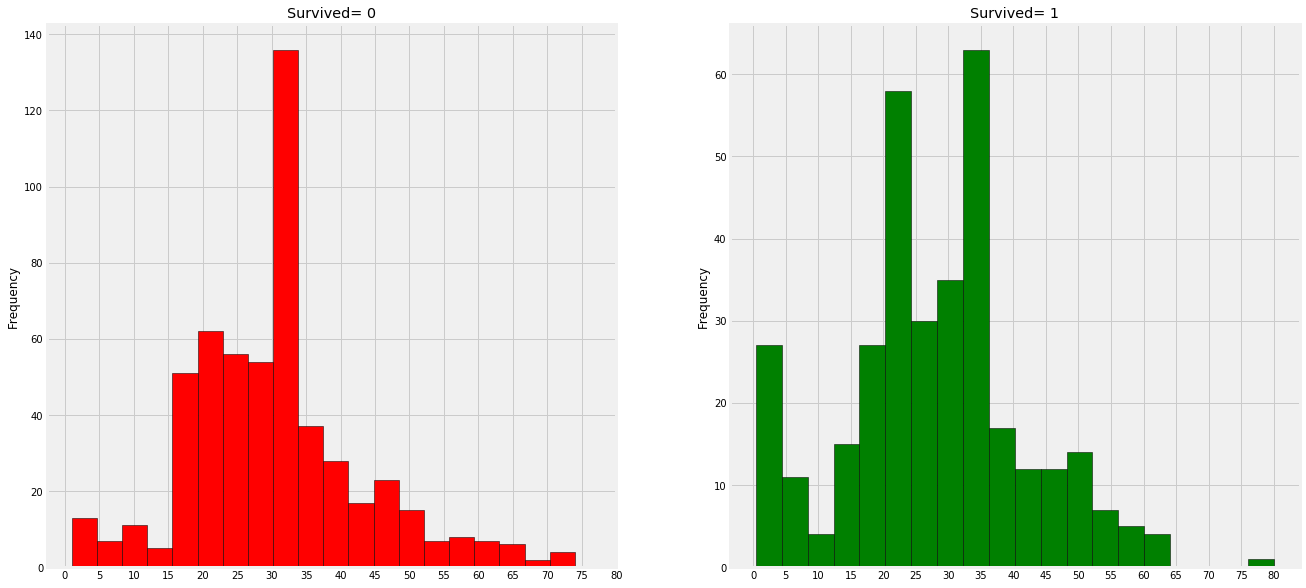

In [20]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

### Observations:
1)幼儿(5岁以下)被大量拯救 (妇女和儿童优先政策)。

2)年龄最长的乘客得救了(80岁)。

3)死亡人数最多的年龄组为30-40岁。

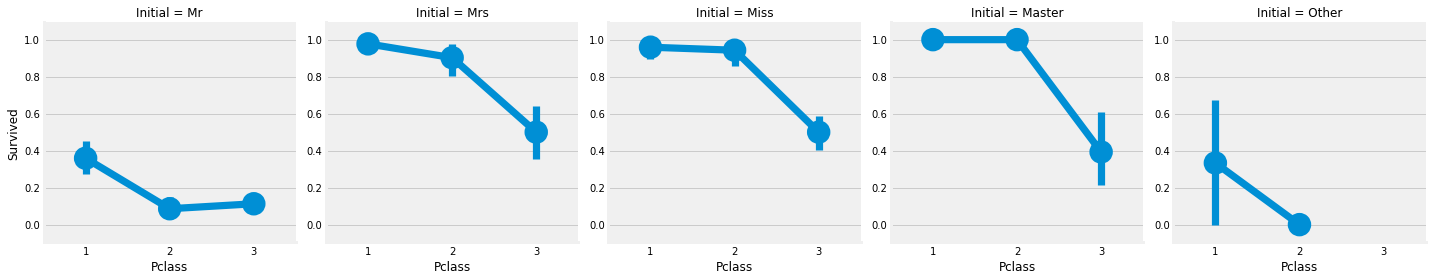

In [21]:
sns.factorplot('Pclass','Survived',col='Initial',data=data)
plt.show()

妇女和儿童优先的政策适用于各个阶级。

## Embarked--> Categorical Value 登舱康扣

In [22]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True).style.background_gradient(cmap='summer_r')

### 不同的登船港有不同的生存机会

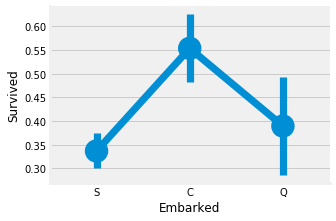

In [23]:
sns.factorplot('Embarked','Survived',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

C港的存活率最高，约为0.55，而S港的存活率最低。

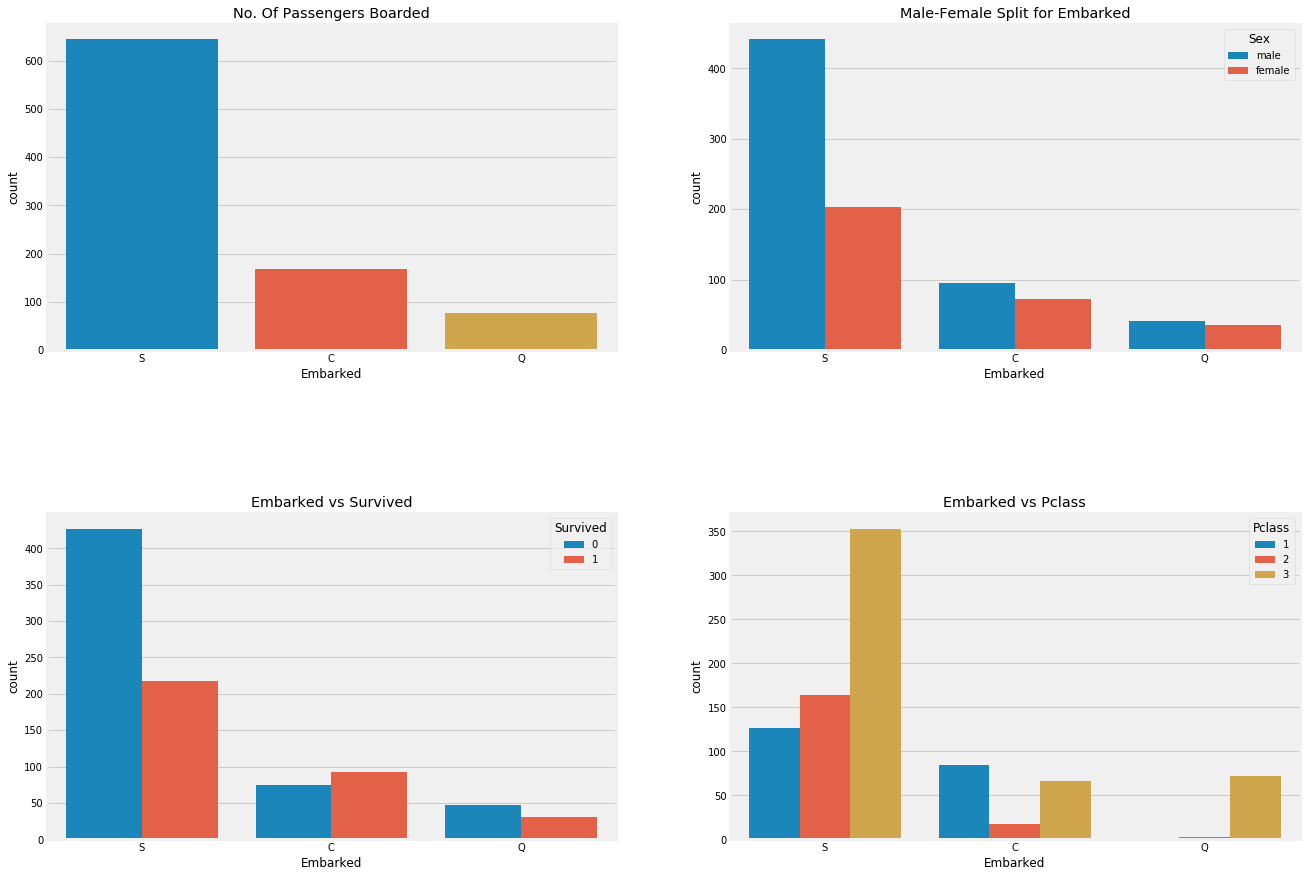

In [24]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

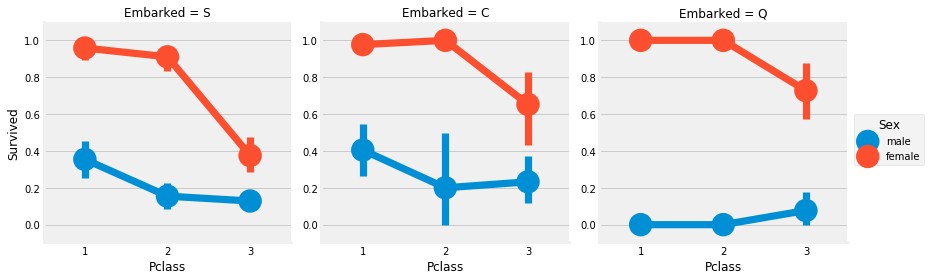

In [25]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

### 替换Embarked的NaN值

我们看到从S港上船的乘客最多，我们用S代替NaN。

In [26]:
data['Embarked'].fillna('S',inplace=True)

In [27]:
data.Embarked.isnull().any()# Finally No NaN values

False

## SibSip-->Discrete Feature
这个特征表示某人是独自一人还是与家人在一起。

In [28]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


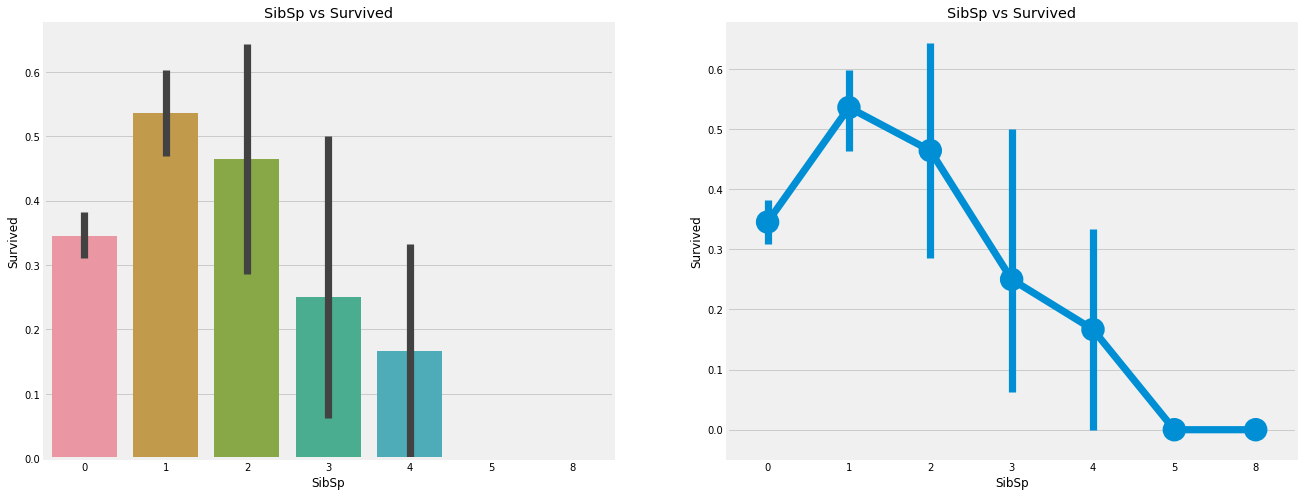

In [29]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [30]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


### Observations:

从barplot和factorplot可以看出，如果一名乘客独自在飞机上没有兄弟姐妹，他的存活率为34.5%。如果兄弟姐妹的数量增加，存活率会减少。也就是说，如果有家人在船上，会尽量救他们，而不是先救我自己。

## 费用Fare--> Continous Feature

In [31]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


此行最高的花费为512，最低的花费为0元，平均费用为32.204元

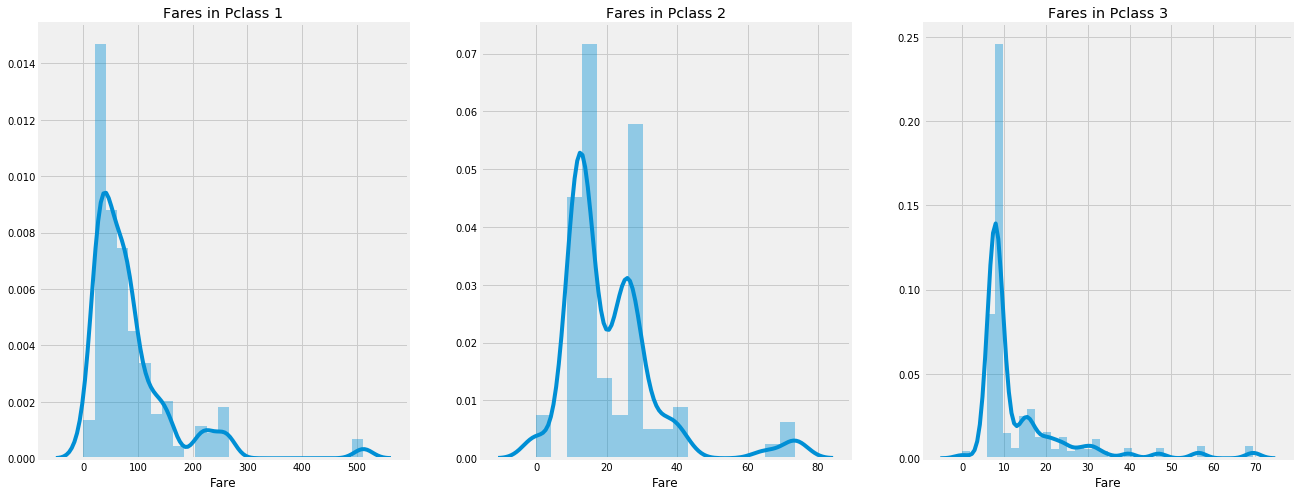

In [32]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

## 对所有特征的总结
**性别:** 女性的生存机会比男性高。

**舱等级: 有一个明显的趋势是，头等舱乘客的生存几率会更高。 3等舱的存活率很低.**

**年龄:** 5-10岁的儿童有很高的生存机会。15岁至35岁的乘客死亡人数很多。

**登船港口:** 尽管大多数头等舱的乘客是在S港登船，但在C港登船的旅客生存率确比S港高，在Q港登船的旅客都是3等舱的

**SibSp:** 有1-2个兄弟姐妹、配偶或1-3个父母在船上，比独自一人或跟随一个大家庭一起旅行生存的可能性大。

## 特征之间的相关性

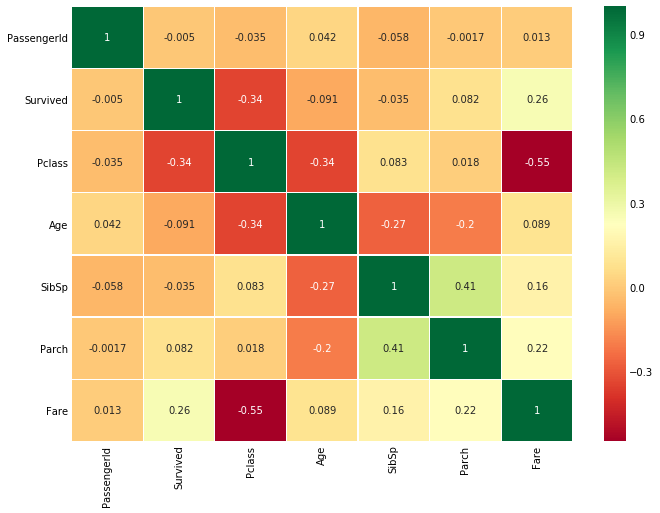

In [33]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### 解释热图

首先要注意的是，只比较数字特性，因为很明显，我们无法在字母或字符串之间建立关联。 

**正相关:** 如果特征A的增加导致特征B的增加，那么它们是正相关的。值**1**表示完全正相关。

**负相关:** 如果特征A的增加导致特征B的减少，那么它们是负相关的。值**-1**表示完全负相关。

假设两个特征高度相关或完全相关，其中一个的增加会导致另一个的增加。这意味着两个特征都包含高度相似的信息，这被称为**多共线性**，它们都包含几乎相同的信息。
我们应该尽量消除冗余特征，因为它可以减少训练时间和许多这样的优点。

从上面的热图，我们可以看到这些特征没有太多的相关性。

# **问题建模**
## Part2: 特性工程和数据清理

## 将年龄分箱

#### Problem With Age Feature:
年龄是一个连续的特征，要按他们的年龄来分组，就必须对数据进行分箱处理

年龄值的范围是0-80，我们将年龄分成5部分

In [34]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [35]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')#checking the number of passenegers in each band

,Age_band
1,382
2,325
0,104
3,69
4,11


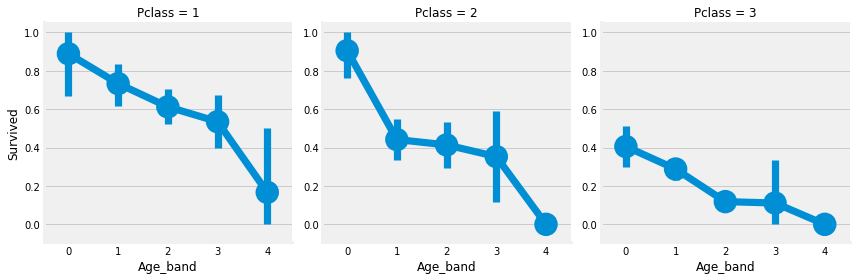

In [36]:
sns.factorplot('Age_band','Survived',data=data,col='Pclass')
plt.show()

True that..the survival rate decreases as the age increases irrespective of the Pclass.

## Family_Size and Alone
At this point, we can create a new feature called "Family_size" and "Alone" and analyse it. This feature is the summation of Parch and SibSp. It gives us a combined data so that we can check if survival rate have anything to do with family size of the passengers. Alone will denote whether a passenger is alone or not.

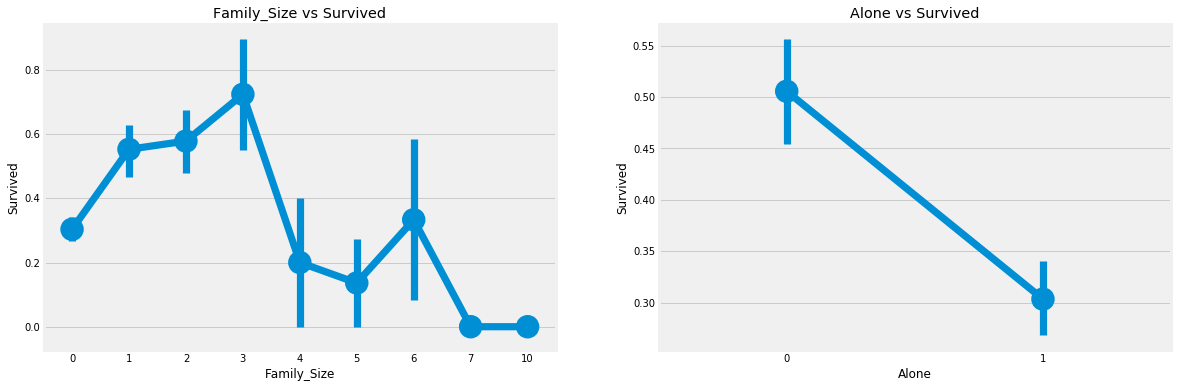

In [37]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

**Family_Size=0 means that the passeneger is alone.** Clearly, if you are alone or family_size=0,then chances for survival is very low. For family size > 4,the chances decrease too. This also looks to be an important feature for the model. Lets examine this further.

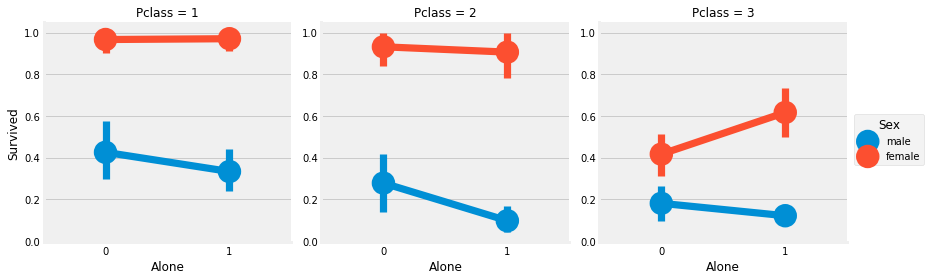

In [38]:
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

It is visible that being alone is harmful irrespective of Sex or Pclass except for Pclass3 where the chances of females who are alone is high than those with family.

## Fare_Range

Since fare is also a continous feature, we need to convert it into ordinal value. For this we will use **pandas.qcut**.

So what **qcut** does is it splits or arranges the values according the number of bins we have passed. So if we pass for 5 bins, it will arrange the values equally spaced into 5 seperate bins or value ranges.

In [39]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


As discussed above, we can clearly see that as the **fare_range increases, the chances of survival increases.**

Now we cannot pass the Fare_Range values as it is. We should convert it into singleton values same as we did in **Age_Band**

In [40]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

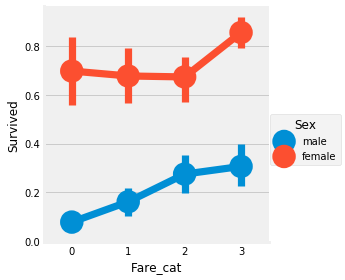

In [41]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

Clearly, as the Fare_cat increases, the survival chances increases. This feature may become an important feature during modeling along with the Sex.

## 将字符串值转换为数值

由于我们不能将字符串传递给机器学习模型，我们需要将诸如Sex、装船等特性转换为数值。

In [42]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

### 删除不需要的特征

**姓名**--> 我们不需要姓名特性，没什么价值

**年龄**--> 我们已对年龄进行分箱，得到了Age_band特征

**票**--> 没用

**费用**--> 我们已对票价进行分箱，得到了Fare_cat特征

**客舱**--> 有许多NaN值，无用的特性。

**Fare_Range**--> 我们已有fare_cat功能。

**PassengerId**--> 无法被归类。

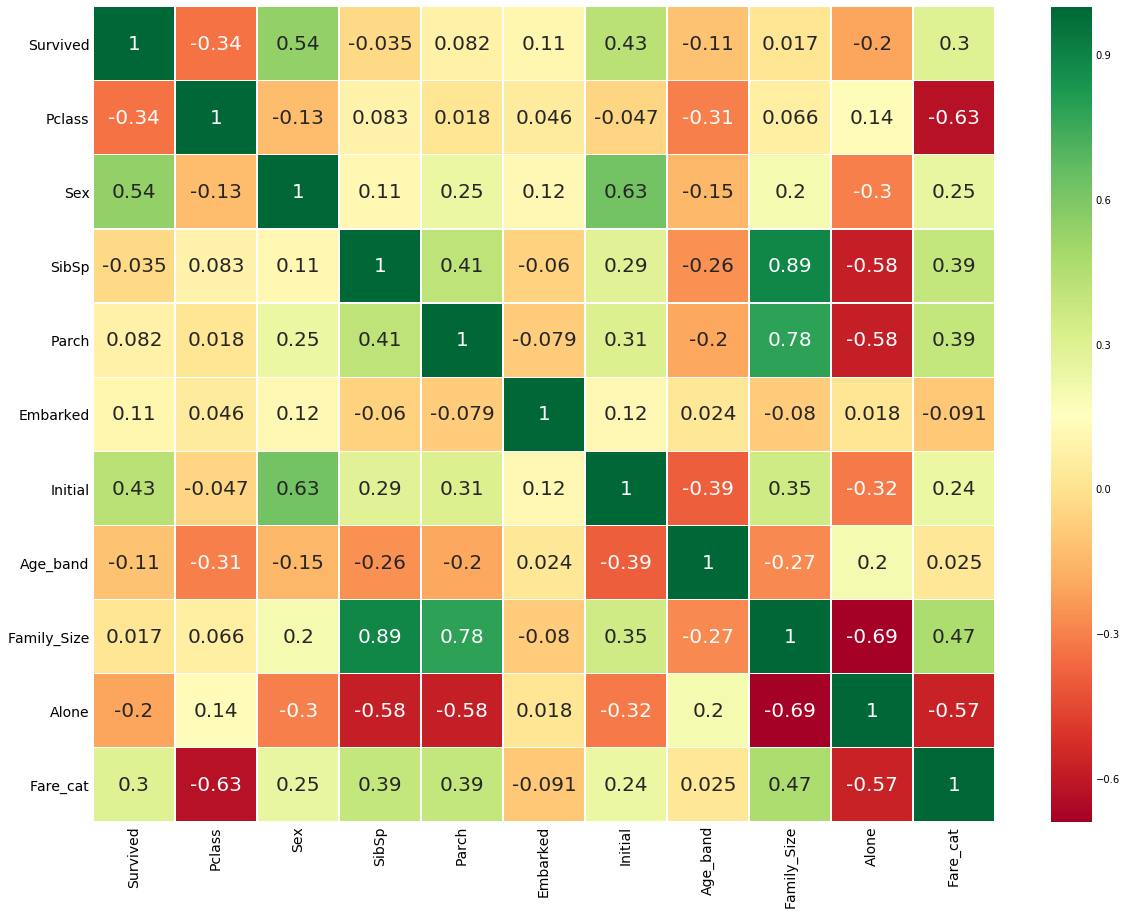

In [43]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# **模型求解**

以下是我将使用的算法来制作模型:

1)Logistic Regression

2)Support Vector Machines(Linear and radial)

3)Random Forest

4)K-Nearest Neighbours

5)Naive Bayes

6)Decision Tree

7)Logistic Regression

In [44]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [45]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

### Radial Support Vector Machines(rbf-SVM)

In [46]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522


### Linear Support Vector Machine(linear-SVM)

In [47]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.817164179104


### Logistic Regression

In [48]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.817164179104


### Decision Tree

In [49]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))


The accuracy of the Decision Tree is 0.80223880597


### K-Nearest Neighbours(KNN)

In [50]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.832089552239


当我们改变n_neighbors属性的值时，KNN模型的准确性也随之改变。缺省值为5。让我们检查各种n_neighbors值的准确性。

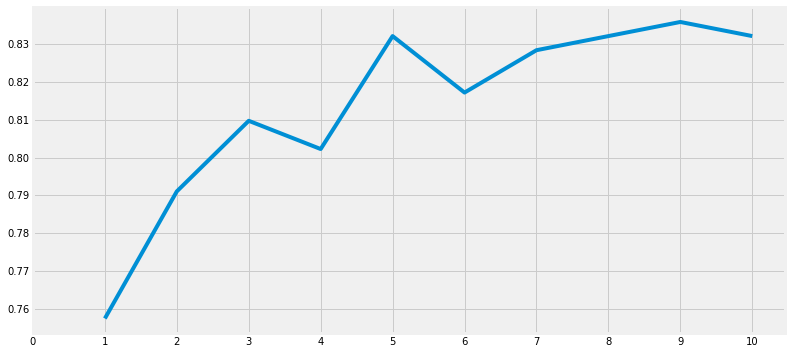

Accuracies for different values of n are: [ 0.75746269  0.79104478  0.80970149  0.80223881  0.83208955  0.81716418
  0.82835821  0.83208955  0.8358209   0.83208955] with the max value as  0.835820895522


In [51]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

### Gaussian Naive Bayes

In [52]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.813432835821


### Random Forests

In [53]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.809701492537


![aa](https://cdncontribute.geeksforgeeks.org/wp-content/uploads/fittings.jpg)

![aa](https://pic2.zhimg.com/80/v2-ba86376ec8d7c14c0d19c5785a7b2c39_720w.jpg)![54](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

## 方差、偏差均衡
#### 注意bias(偏差)与variance(方差)的区别

**偏差：**描述的是预测值（估计值）的期望与真实值之间的差距。偏差越大，越偏离真实数据，如上图所示。

**方差：**描述的是预测值的变化范围(与真实值无关)，离散程度，也就是离其期望值的距离。方差越大，数据的分布越分散，如上图所示。

#### 欠拟合与过拟合
- 欠拟合是指模型未能捕捉到数据的重要方面，模型学习能力不足，因而导致泛化能力弱，导致训练误差大
- 过拟合常常在模型学习能力过强的情况中出现，此时模型学习能力太强，以至于将训练集单个样本自身的特点都能捕捉到，并将其认为是"一般规律"，这种情况也会导致模型泛化能力下降，过拟合往往能较好地学习训练集数据的性质，而在**测试集**上的**性能较差**

#### 解决思路
偏差：实际上也可以称为避免欠拟合。
- 寻找更好的特征 -- 具有代表性。
- 用更多的特征 -- 增大输入向量的维度。（增加模型复杂度）

方差：避免过拟合
- 增大数据集合 -- 使用更多的数据，减少数据扰动所造成的影响
- 减少数据特征 -- 减少数据维度，减少模型复杂度
- 正则化方法
- 交叉验证法

为了克服这些问题并得到一个通用的模型，我们使用了**交叉验证**。

# 交叉验证

很多时候，数据是不平衡的，也就是说，可能某个实例的数量很多，而其他类实例的数量较少。因此，我们应该在数据集的每个实例上训练和测试我们的算法。取准确性的平均值。

1)K-折交叉验证的工作原理是将数据集划分为k个子集。

2)假设我们将数据集分成(k=5)个部分。我们预留1部分用于测试，并在4部分上训练算法。

3)我们通过在每次迭代中改变测试部分并在其他部分上训练算法来继续这个过程。然后对精度和误差取平均值，得到算法的平均精度。

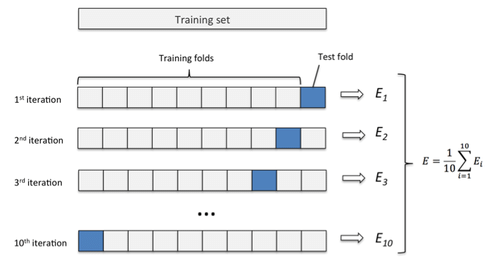

In [54]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793471,0.047797
Radial Svm,0.828290,0.034427
Logistic Regression,0.805843,0.021861
KNN,0.813783,0.041210
Decision Tree,0.805868,0.028634
Naive Bayes,0.801386,0.028999
Random Forest,0.811473,0.031523


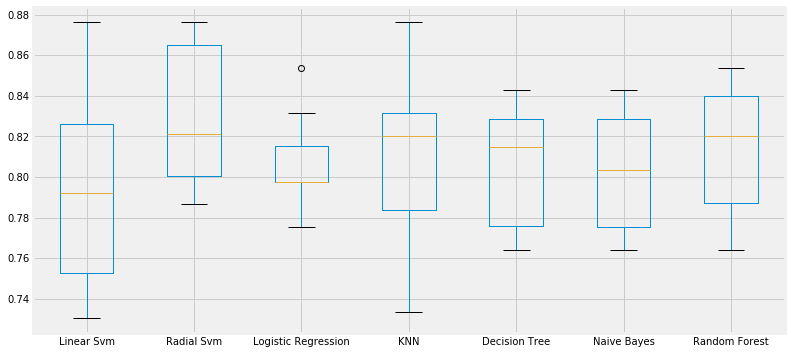

In [55]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

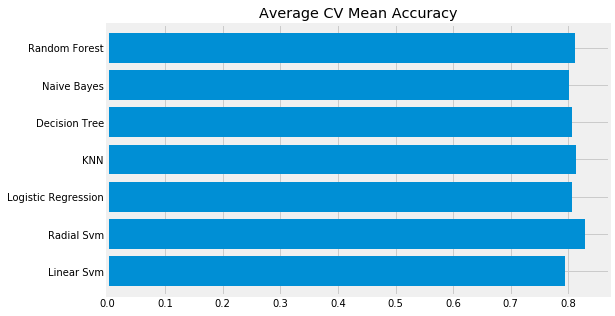

In [56]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

## 混淆矩阵

它给出了分类器正确分类和错误分类的数量

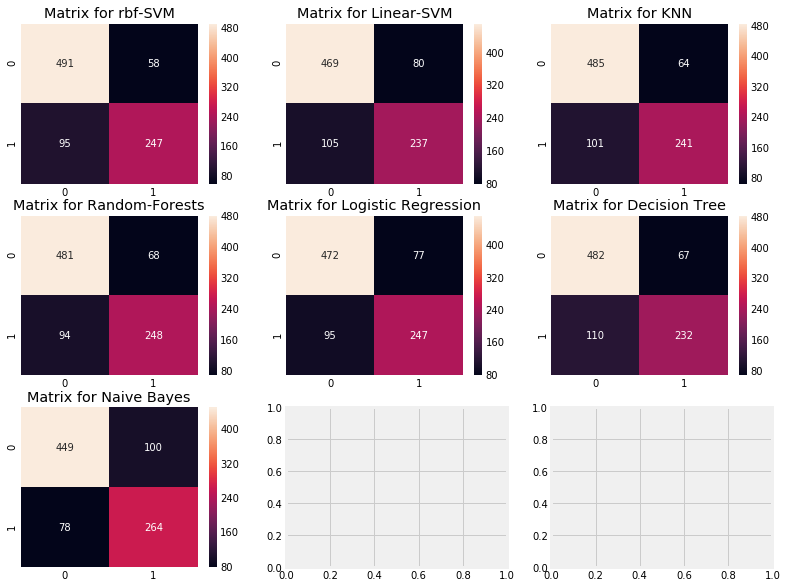

In [57]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

### 超参数优化

超参数是在模型拟合之前设置的模型参数，决定模型的表现，通常情况下，需要对超参数进行优化，给学习机选择一组最优超参数，以提高学习的性能和效果。


超参数的一些示例：
- 聚类中类的个数
- 话题模型中话题的数量
- 模型的学习率
- 深层神经网络隐藏层数
- 树的数量或树的深度
- 矩阵分解中潜在因素的数量
- k均值聚类中的簇数


#### 主流的**超参数调优**方法有以下几种
- 手动调参
- 网格搜索
- 随机搜索
- 贝叶斯搜索

本实验中我使用**网格搜索**的方法对SVM和RandomForests两个分类器的超参数进行调优

#### SVM调优

In [58]:
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
0.828282828283
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   15.7s finished


#### Random Forests调优

In [59]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   24.4s finished


0.817059483726
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


通过结果可以发现本实验中对SVM来说**C**参数取**0.05**，**gamma**值取**0.1**时效果最好

对随机森林来说，**n_estimators**设定为**900**时效果最好

## 我们发现，其实上述的几种方法在准确度上没有明显的差异，为了继续提高模型预测的准确率，我引入***集成学习***的方法：

![](https://img-blog.csdnimg.cn/2019081709593198.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2FiY2RyYWNoZWw=,size_16,color_FFFFFF,t_70)

# **集成学习**

集成是提高模型准确性或性能的好方法。它可以减少了模型的结果的方差，使其更**可靠**。

简单地说，它是用各种简单模型的组合来创建一个强大的单一模型。

集成有以下方式:

1)Voting Classifier

2)Bagging

3)Boosting

## Voting Classifier

在此我们使用**软投票**的方法

软投票就是计算得出不同方法的分类概率的均值，最后选择均值最高的作为预测结果。

In [60]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.820895522388
The cross validated score is 0.823766031097


## Bagging

套袋法是一种通用的集成方法。它的工作原理是在数据集的小分区上应用类似的分类器，然后取所有预测的平均值。 

![ss](https://pic1.zhimg.com/9edf53941bf363de1fb186433cce6e28_r.jpg?source=1940ef5c)

#### Bagged KNN

Bagging在具有大方差的模型中效果最好。例子是决策树或随机森林。

In [61]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522
The cross validated score for bagged KNN is: 0.814889342867


### 在此与上一种集成方法相比较，准确率有所提高，提高了一个百分点


#### Bagged DecisionTree


In [62]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.824626865672
The cross validated score for bagged Decision Tree is: 0.820482635342


## Boosting

Boosting是一种利用分类器学习顺序的技术，它可以一步步提高弱分类器的能力

首先在完整的数据集上训练模型，模型将得到一些正确的实例，和一些错误的结果。那么在下次迭代中, 模型将会更多地关注错误的预测结果或给予它更多的权重。试图将错误的预测结果变为正确的。继续迭代, 在模型中加入新的分类器，直到达到精度限制。

总的来说：

- 步骤1：所有分布下的基础学习器对于每个观测值都应该有相同的权重

- 步骤2：如果第一个基础的学习算法预测错误，则该点在下一次的基础学习算法中有更高的权重

- 步骤3：迭代第2步，直到到达预定的学习器数量或预定的预测精度。

最后，将输出的多个弱学习器组合成一个强的学习器，提高模型的整体预测精度。Boosting总是更加关注被错误分类的弱规则。

## AdaBoost(Adaptive Boosting)  自适应增强

#### 有了两个问题需要去解决：
- 在每一轮如何改变训练数据的权值或概率分布？
- 如何将弱分类器组合成一个强分类器？

通过例子来解释过程

- Box 1: 可以看到我们假设所有的数据点有相同的权重（正号、负号的大小都一样），并用一个决策树桩D1将它们分为两部分。我们可以看到这个决策树桩将其中的三个正号标记的数据点分类错误，因此我们将这三个点赋予更大的权重交由下一个预测树桩进行分类。
- Box 2: 在这里可以看到三个未被正确分类的（+）号的点的权重变大。在这种情况下，第二个决策树桩D2试图将这三个错误的点准确的分类，但是这又引起新的分类错误，将三个（-）号标记的点识别错误，因此在下一次分类中，这三个（-）号标记的点被赋予更大的权重。
- Box 3: 在这里三个被错误分类的（-）号标记的点被赋予更大的权重，利用决策树桩D3进行新的分类，这时候又产生了新的分类错误，图中用小圆圈圈起来的一个负号点和两个正号点
- Box 4: 在这里，我们将D1、D2和D3三个决策器组合起来形成一个复杂的规则，可以看到这个组合后的决策器比它们任何一个弱分类器表现的都足够好。

迭代，直到分类器数量达到预定值或预测精度达到预定值




![xxx](https://www.biaodianfu.com/wp-content/uploads/2020/09/adaboost.png)

本实验中弱分类器选取的是决策树

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.824952616048


#### Stochastic Gradient Boosting

弱分类器选取的是决策树

可以调整参数以优化算法的性能：

- n_estimators：它控制了弱学习器的数量
- learning_rate：控制在最后的组合中每个弱分类器的权重，需要在learning_rate和n_estimators间有个权衡
- base_estimators：它用来指定不同的ML算法。

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.818286233118


#### XGBoost

In [ ]:
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.810471002156


AdaBoost得到了最高的准确率

下面我尝试用超参数调优来增加它的准确度

#### Hyper-Parameter Tuning for AdaBoost

In [ ]:
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  6.1min finished


0.83164983165
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=200, random_state=None)


利用adaboost集成我们达到了 **83.16%的准确率 (n_estimators=200 and learning_rate=0.05)**

## Stacking


# **结果分析与讨论**

### Confusion Matrix for the Best Model

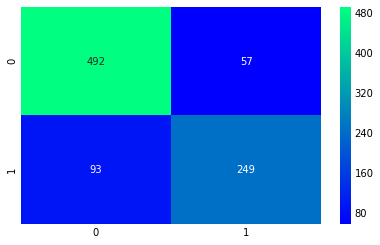

In [ ]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

## Feature Importance

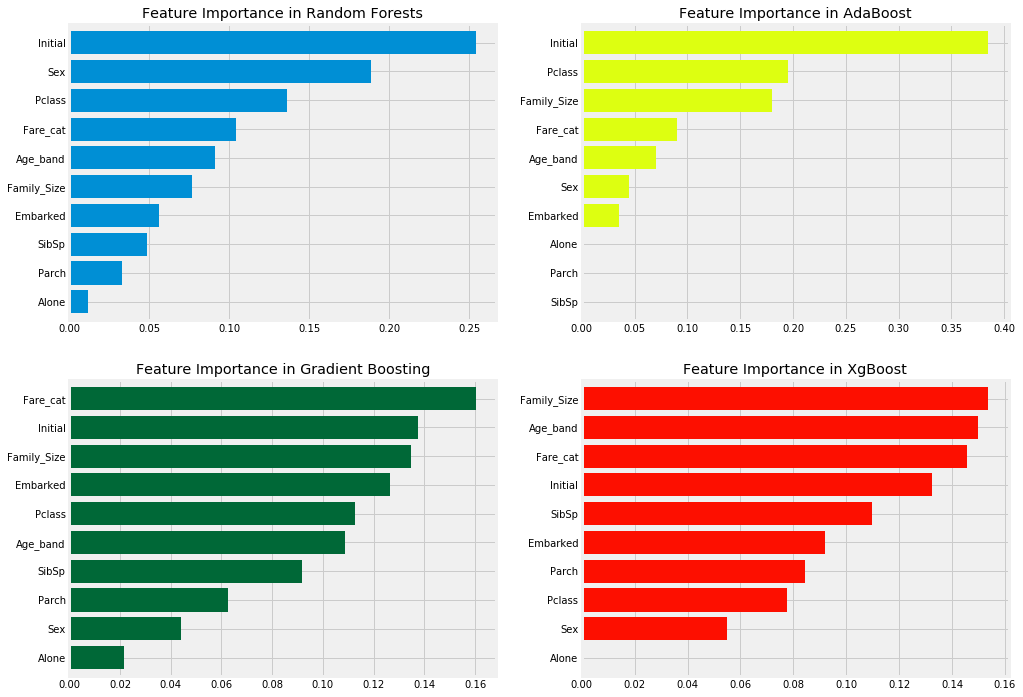

In [ ]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

We can see the important features for various classifiers like RandomForests, AdaBoost,etc.

#### Observations:

1)Some of the common important features are Initial,Fare_cat,Pclass,Family_Size.

2)The Sex feature doesn't seem to give any importance, which is shocking as we had seen earlier that Sex combined with Pclass was giving a very good differentiating factor. Sex looks to be important only in RandomForests.

However, we can see the feature Initial, which is at the top in many classifiers.We had already seen the positive correlation between Sex and Initial, so they both refer to the gender.

3)Similarly the Pclass and Fare_cat refer to the status of the passengers and Family_Size with Alone,Parch and SibSp.